# Decision Trees and Decision Tree Ensembles for ENSO Prediction
David John Gagne

## Installation Notes
This notebook uses newer versions of the Python stack than the notebook in Lecture 1. You can access a pre-installed conda environment for this notebook by creating a `.condarc` file in your home directory or editing an existing one to include the following element:

```yaml
envs_dirs:
  - /glade/work/dgagne/conda-envs/
```

If you want to install your own environment, run the following command in the terminal or run the cell below.
```bash
conda env create -f ../environment.yml --yes
```

After installing the environment, you should see the `aiml-tutorial` appear in the Select Kernel menu. Switch to the `aiml-tutorial` kernel to run the rest of the notebook.

In [ ]:
! conda env create -f ../environment.yml --yes

In [71]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
sys.path.append('../utils/')
from ENSO_utils import get_data, get_nino34, plot_nino34, get_nino34events, split_data, standardize_data, make_cat, plot_input, plot_inputvector, plot_datasplit, plot_datasplitcat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

%matplotlib inline

## Data
We will be using the same ERSST data from Lecture 1 but with a bit of a twist. Instead of treating this as a classification problem, we will be predicting the Niño Index as a lagged regression problem. Essentially we will use the SST field at time $t$ to estimate the Niño Index at time $t+l$ where $l$ is the lag in months. 

In [2]:
def get_nino34(sst):
    ninolat1 = -5
    ninolat2 = 5
    ninolon1 = 190
    ninolon2 = 240
    sstnino = sst.sel(lat=slice(ninolat1, ninolat2),lon=slice(ninolon1, ninolon2))
    nino34 = sstnino["sst"].mean(dim=("lon", "lat")).values
    return nino34

Text(0, 0.5, 'Nino 3.4 Index')

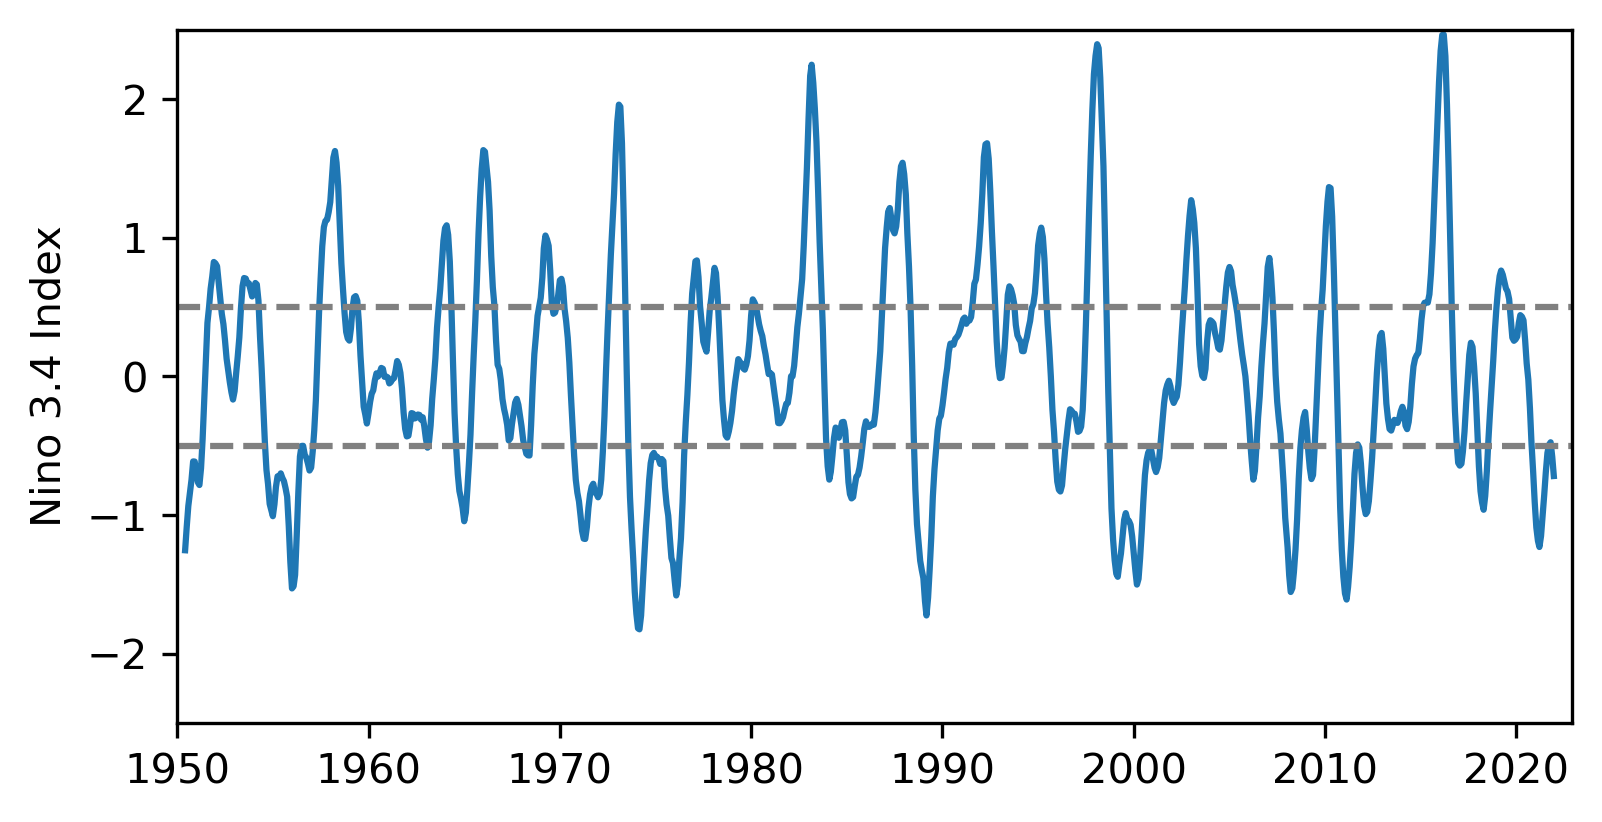

In [3]:
sst_all = xr.open_dataset("../utils/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc")

# Preprocess ANN Input Data:
sst = sst_all.where((sst_all.lat <= 30) & (sst_all.lat >= -30), drop=True)
lat = sst.lat
lon = sst.lon
time = sst.time

# Preprocess ANN Output Data:
nino34 = get_nino34(sst)
times = pd.DatetimeIndex([t.isoformat() for t in sst.time.values])

plt.figure(figsize=(6, 3), dpi=300)
plt.plot(times, nino34)
plt.hlines(0.5,pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"),linestyle='dashed',color='grey')
plt.hlines(-0.5,pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"),linestyle='dashed',color='grey')
plt.ylim(-2.5,2.5)
plt.xlim(pd.Timestamp("1950-01-01"),pd.Timestamp("2022-12-01"))
plt.ylabel("Nino 3.4 Index")

Our first set of models will map the grid cell monthly SST values to the Nino Index. We can increase the lag to make the prediction problem more difficult and hopefully require more nonlocal grid cells for good performance. 

In [7]:
lag = 3
enso_magnitude = 0
sst_arr = sst["sst"].values
# NOTE: this function vectorizes the input
x,y = get_nino34events(sst_arr, nino34, enso_magnitude, vectorize=True)

# The wet mask filters out grid cells over land and allows reconstruction of the mask later.
wet_mask = ~np.isnan(x[0])
x_wet = x[:, wet_mask]
# Split data:
num_samples = y[lag:].shape[0]
train_val_test = [0.7,0.85,1] # set train/val/test fraction
xtrain, xval, xtest, ytrain, yval, ytest, trainind, valind, testind = split_data(num_samples,
                                                                                 train_val_test,
                                                                                 x_wet[:-lag],
                                                                                 y[lag:])


In [8]:
xtrain

array([[-0.51231142, -0.40558564, -0.30874418, ...,  0.5656389 ,
         0.66298524,  0.71673569],
       [-0.71678961, -0.58918418, -0.46565368, ...,  0.56805143,
         0.697284  ,  0.77362649],
       [-0.84385424, -0.70489865, -0.56281548, ...,  0.6128647 ,
         0.7442464 ,  0.82158633],
       ...,
       [-0.21253005, -0.19406942, -0.16163823, ..., -0.1650115 ,
        -0.20083578, -0.23073967],
       [-0.34001429, -0.3436729 , -0.31318464, ..., -0.29138468,
        -0.28148721, -0.27549033],
       [-0.41676192, -0.42639482, -0.38602507, ..., -0.2788922 ,
        -0.24420956, -0.22039663]], shape=(599, 4231))

### 🏃 Exercise 1
Split training data at lags from 1 to 12 months and plot the correlation between mean SST and Nino Index as a function of lag time in months.

In [ ]:
# Exercise 1 CODE GOES HERE


## Model Training
We will compare three tree methods. You are encouraged to play with the hyperparameters of each model and to compare GradientBoostingRegressor with HistGradientBoostingRegressor in terms of both performance and training time. 

For more information about model details and what the hyperparameter settings are:

| User Guide | API |
| -------- | ------- |
| [Decision Trees](https://scikit-learn.org/stable/modules/tree.html) | [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) |
| [Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees) | [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) |
| [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles) | [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) |

In [11]:
print("Fit Decision Tree")
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(xtrain, ytrain)
print("Fit Gradient Boosting")
gb = GradientBoostingRegressor(max_depth=3)
gb.fit(xtrain, ytrain)
print("Fit Random Forest")
rf = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=4)
rf.fit(xtrain, ytrain)


Fit Decision Tree
Fit Gradient Boosting
Fit Random Forest


,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Plot a time series of predictions from each model against observations. What is similar or different about each set of predictions? What hyperparameter choices increase the sharpness of the predictions? 

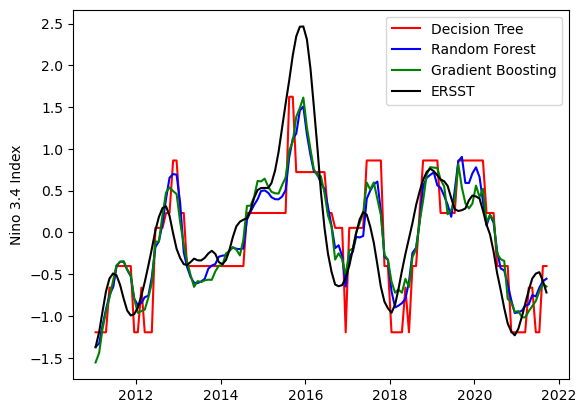

In [6]:
plt.plot(times[testind],dt.predict(xtest), color='r', label="Decision Tree")
plt.plot(times[testind],rf.predict(xtest), color='b', label="Random Forest")
plt.plot(times[testind],gb.predict(xtest), color='g', label="Gradient Boosting")

plt.plot(times[testind], ytest, color='k', label="ERSST")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.savefig("dt_enso_pred.png", dpi=300, bbox_inches="tight")

### 🏃 Exercise 2
Calculate train, validation, and test set metrics for each of the three models. Use metrics from [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) or code your own. 

In [ ]:
# Exercise 2 CODE GOES HERE


## Feature Importance Maps
In addition to making predictions, these models can be used to identify where the source of predictability in the SST field comes from. By extracting the feature importance fields from each model and mapping them, we should be able to see how much each model utilizes information outside the Nino region for their predictions. 

### 🏃 Exercise 3
How do these fields change with different hyperparameters and different lags? Edit the code below to generate plots comparing feature importance maps as a function of tree depth. Also compare importances as a function of lag time for a single model.

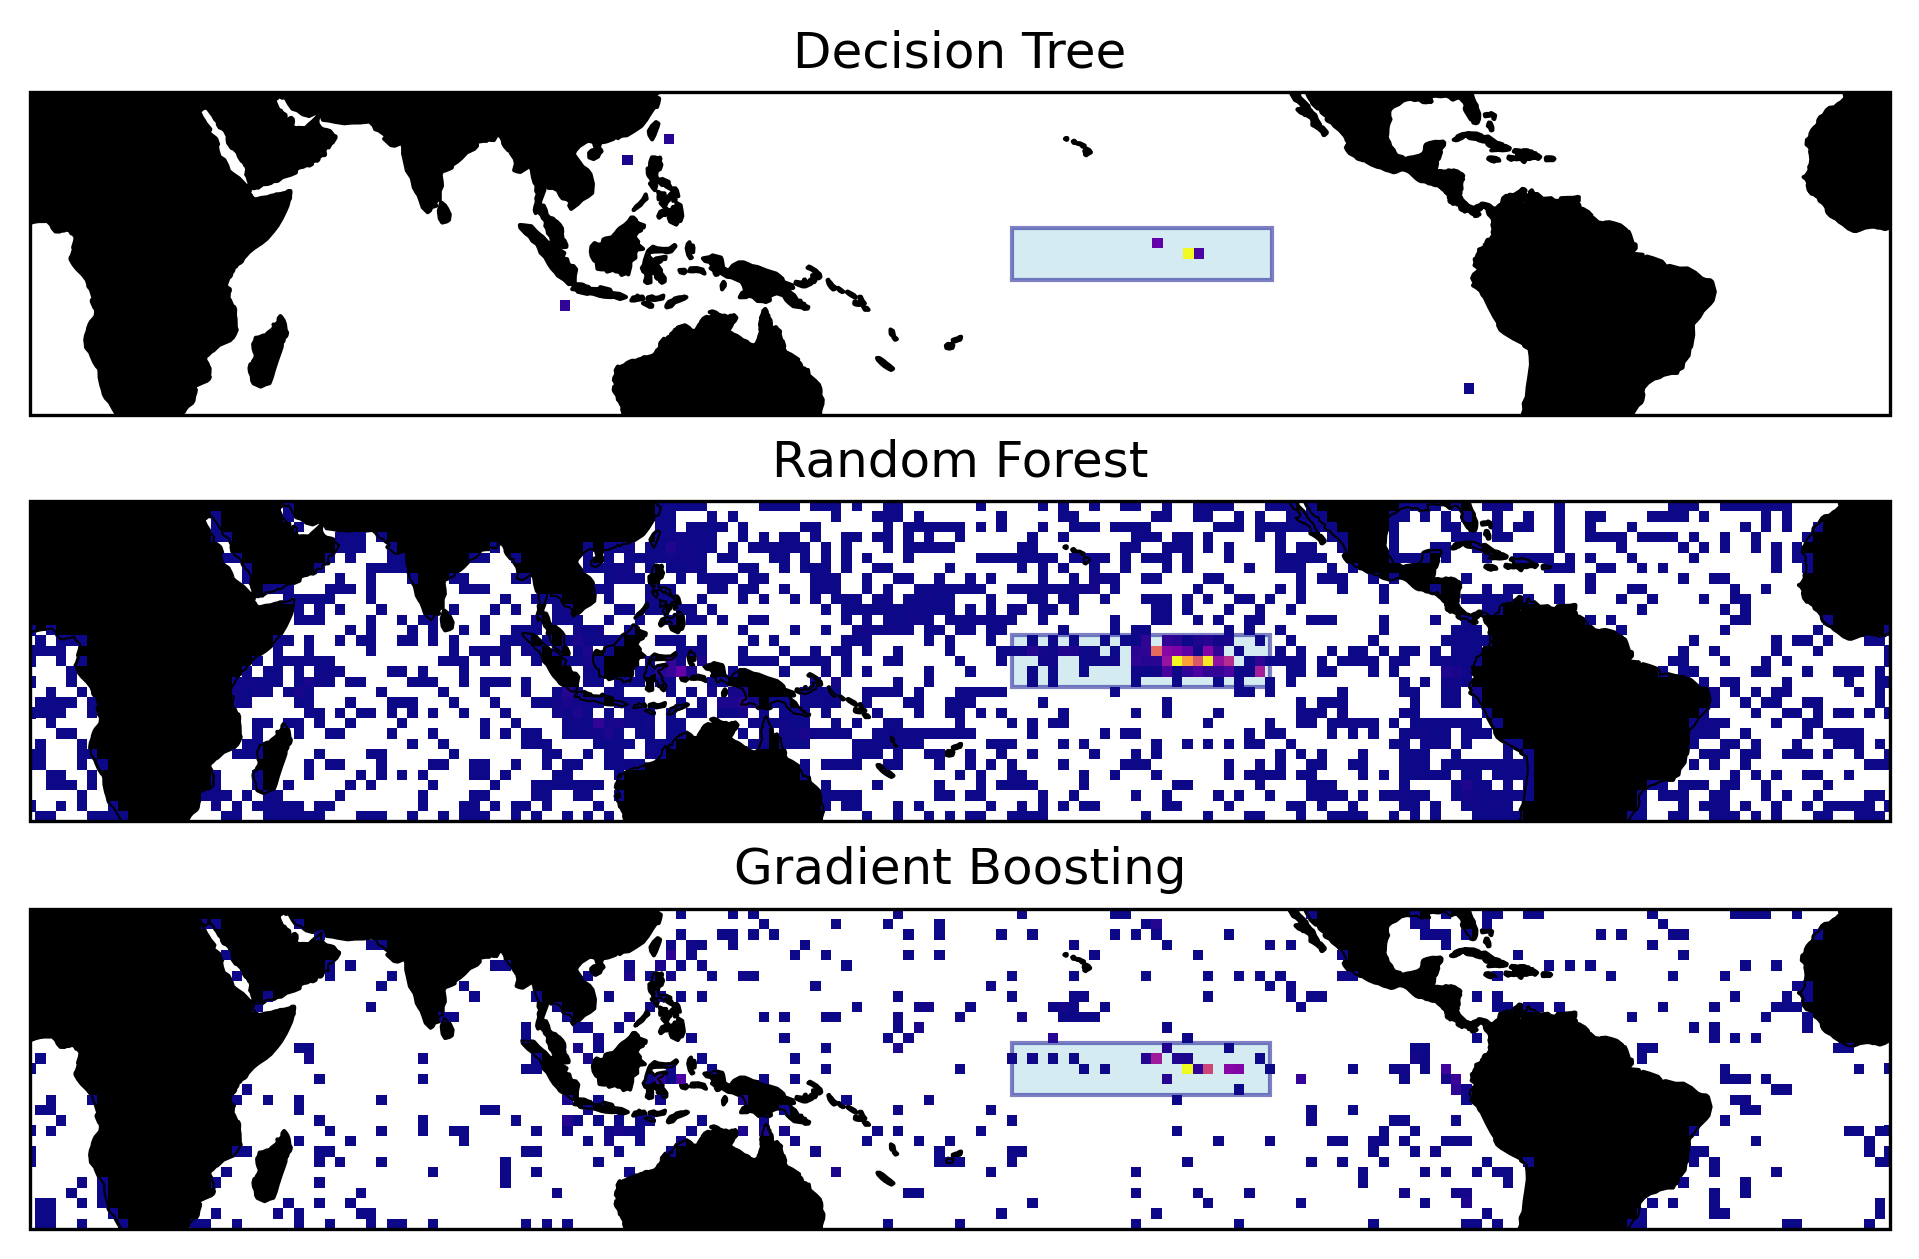

In [27]:
proj = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(3, 1, figsize=(8, 5), dpi=300, subplot_kw=dict(projection=proj))
models = [dt, rf, gb]
model_names = ["Decision Tree", "Random Forest", "Gradient Boosting"]
for m, model in enumerate(models):
    fi = model.feature_importances_
    fi_grid = np.zeros(wet_mask.shape)
    fi_grid[wet_mask] = fi
    fi_grid = fi_grid.reshape(lat.size, lon.size)
    
    axes[m].coastlines(lw=0.5)
    axes[m].add_feature(cfeature.LAND, color='k')
    ninolat1 = -5
    ninolat2 = 5
    ninolon1 = 190
    ninolon2 = 240
    
    rect = patches.Rectangle((ninolon1, ninolat1), ninolon2-ninolon1, ninolat2-ninolat1, 
                             linewidth=1, 
                             edgecolor='darkblue', 
                             facecolor='lightblue', 
                             alpha=0.5, transform=transform)
    axes[m].add_patch(rect)
    axes[m].pcolormesh(lon, lat, np.ma.array(fi_grid, mask=fi_grid==0), cmap="plasma", transform=transform)
    axes[m].set_title(model_names[m])
plt.savefig("feature_importances.png", dpi=300, bbox_inches="tight")


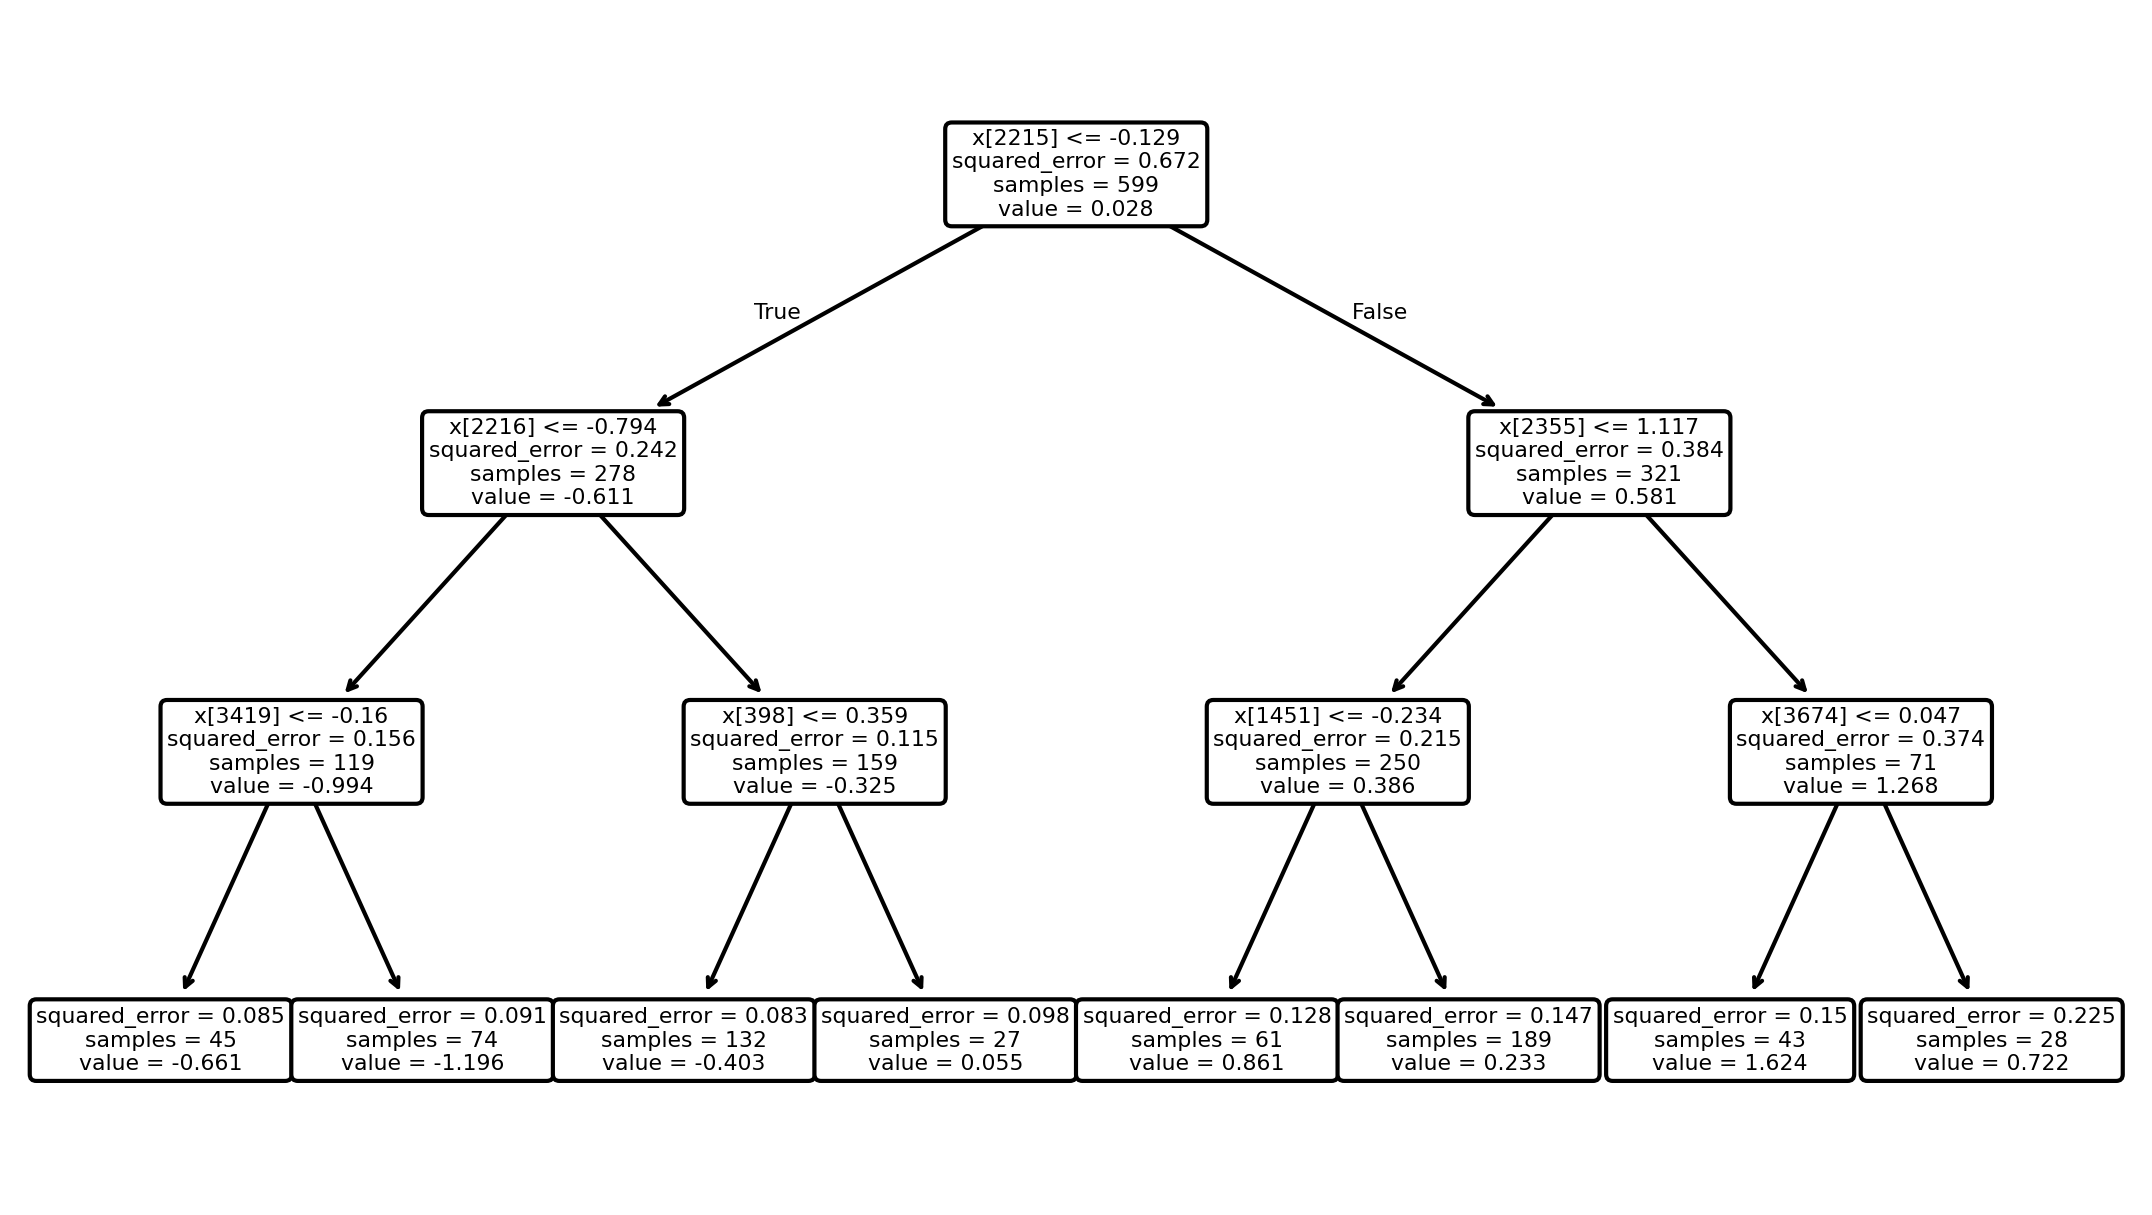

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
_ = plot_tree(dt, max_depth=5, ax=ax, rounded=True, )

## Alternate Data Preprocessing
Decision tree model treats each grid cell as independent, but what if we want to encode spatial patterns into the decision tree input space? Traditionally, statistical dimensionality reduction methods are used for this. A classic method for this is Principal Component Analysis (PCA; or Empirical Orthogonal Functions, Proper Orthogonal Decomposition, etc.). PCA is implemented in Scikit-Learn thankfully, so we can investigate whether the use of PCA improves test error, interpretability, both, or neither.

Note that PCA is most effective when data are normalized rather than using the raw values for each grid cell. The StandardScaler transform takes care of this for us.

In [53]:
scaler = StandardScaler()
pc = PCA(n_components=20)
xtrain_norm = scaler.fit_transform(xtrain)
xval_norm = scaler.transform(xval)
xtest_norm = scaler.transform(xtest)
xtrain_pc = pc.fit_transform(xtrain_norm)
xval_pc = pc.transform(xval_norm)
xtest_pc = pc.transform(xtest_norm)

### 🏃 Exercise 4
Edit the code below to visualize each principal component spatially. What physical phenomena if any do the PCs correspond to?

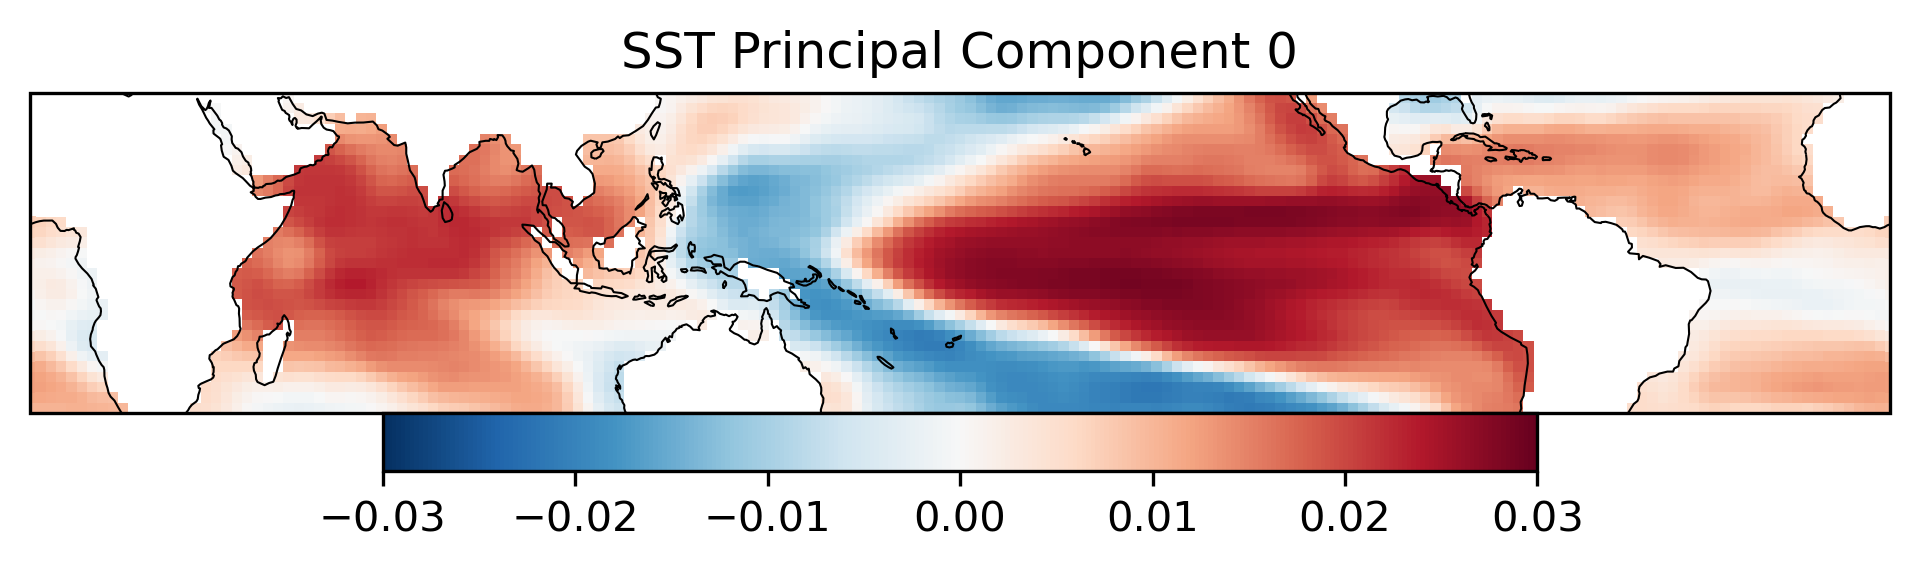

In [85]:
pc_idx = 0
fi = pc.components_[pc_idx]
fi_grid = np.zeros(wet_mask.shape)
fi_grid[wet_mask] = fi
fi_grid = fi_grid.reshape(lat.size, lon.size)
proj = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree(central_longitude=0)
fig, ax= plt.subplots(1, 1, figsize=(8, 5), dpi=300, subplot_kw=dict(projection=proj))
ax.coastlines(lw=0.5)
ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

rect = patches.Rectangle((ninolon1, ninolat1), ninolon2-ninolon1, ninolat2-ninolat1, 
                         linewidth=1, 
                         edgecolor='darkblue', 
                         facecolor='lightblue', 
                         alpha=0.5, transform=transform)
ax.add_patch(rect)
img =  ax.pcolormesh(lon, lat, np.ma.array(fi_grid, mask=fi_grid==0), cmap="RdBu_r", transform=transform, vmin=-0.03, vmax=0.03)
plt.colorbar(img, ax=ax, orientation="horizontal", pad=0, fraction=0.05)
plt.title(f"SST Principal Component {pc_idx:d}")
plt.savefig("pc_viz.png", dpi=300, bbox_inches="tight")

Now we will fit each model. Feel free to play with the hyperparameters? Do you notice anything different about the training time for each model?

In [55]:
dt_pca = DecisionTreeRegressor(max_depth=10)
dt_pca.fit(xtrain_pc, ytrain)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [56]:
rf_pca = RandomForestRegressor(n_estimators=10)
rf_pca.fit(xtrain_pc, ytrain)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
gb_pca = GradientBoostingRegressor(n_estimators=100, max_depth=3)
gb_pca.fit(xtrain_pc, ytrain)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


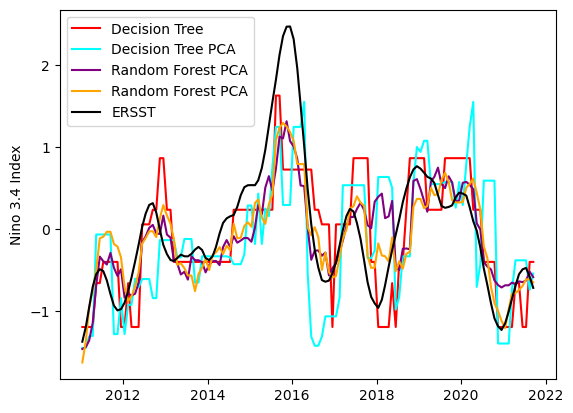

In [58]:
plt.plot(times[testind],dt.predict(xtest), color='r', label="Decision Tree")
plt.plot(times[testind],dt_pca.predict(xtest_pc), color='cyan', label="Decision Tree PCA")
plt.plot(times[testind],rf_pca.predict(xtest_pc), color='purple', label="Random Forest PCA")
plt.plot(times[testind],gb_pca.predict(xtest_pc), color='orange', label="Random Forest PCA")

plt.plot(times[testind], ytest, color='k', label="ERSST")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.savefig("dt_enso_pred.png", dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'Gradient Boosting')

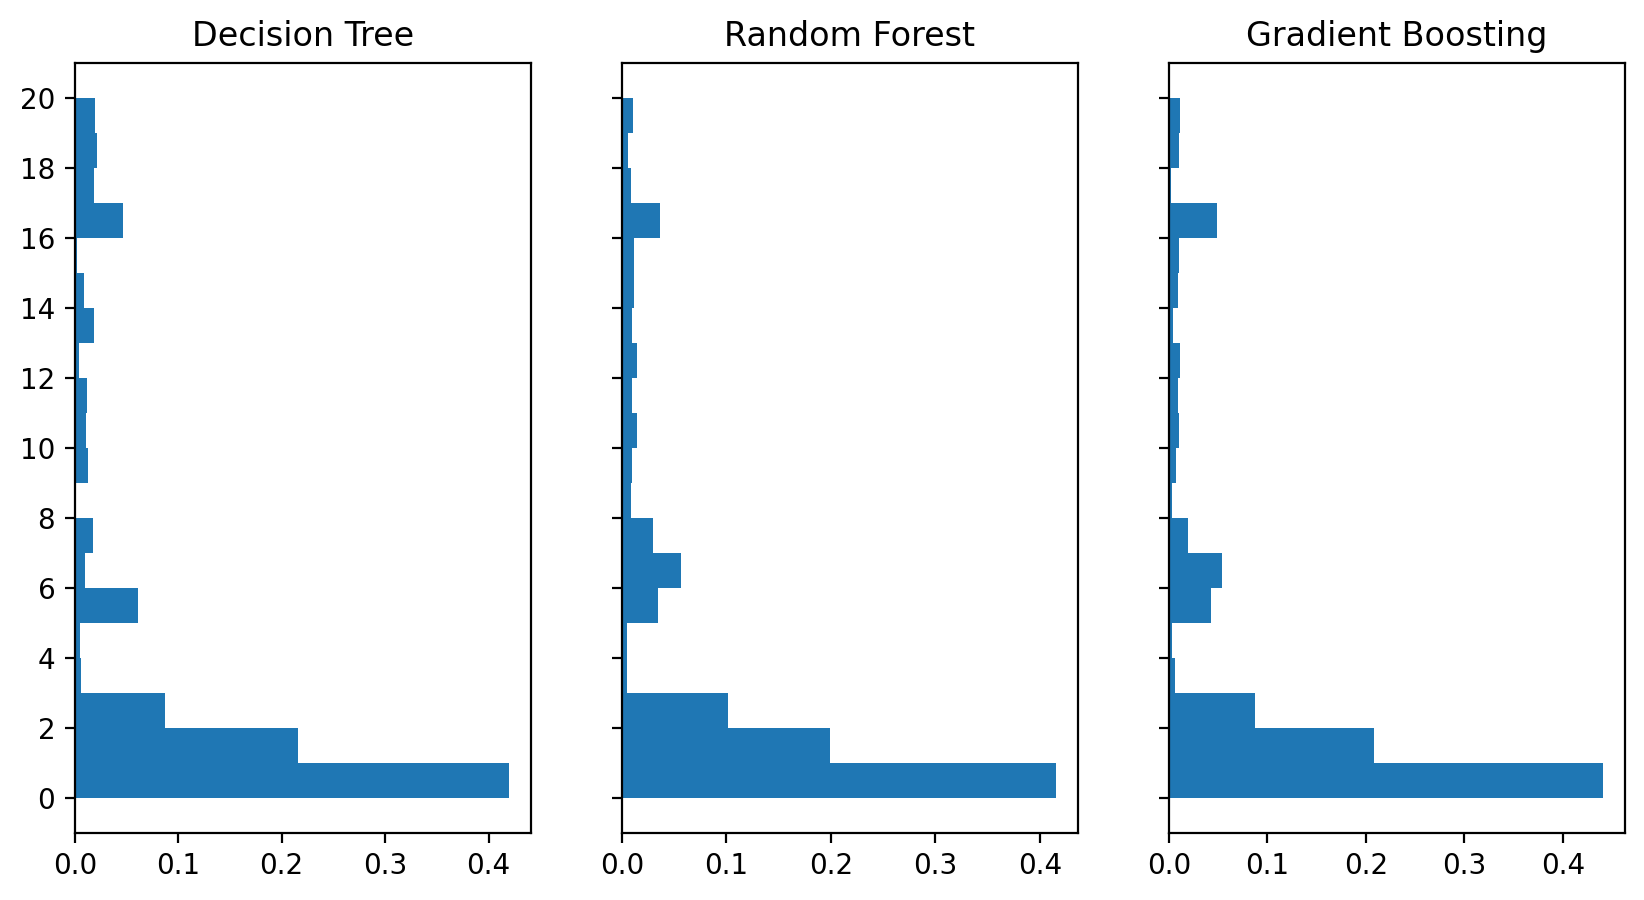

In [70]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 5), dpi=200) 
plt.yticks(np.arange(0, 22, 2))
plt.subplot(1, 3, 1)
plt.barh(np.arange(dt_pca.feature_importances_.size) + 0.5, dt_pca.feature_importances_, 1)
plt.title("Decision Tree")
plt.subplot(1, 3, 2)
plt.barh(np.arange(dt_pca.feature_importances_.size) + 0.5, rf_pca.feature_importances_, 1)
plt.title("Random Forest")
plt.subplot(1, 3, 3)
plt.barh(np.arange(dt_pca.feature_importances_.size) + 0.5, gb_pca.feature_importances_, 1)
plt.title("Gradient Boosting")


## 🏃 Bonus Exercise
Another model-agnostic Explainable AI method is [partial dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html). Read more about them on the Scikit-learn [user guide](https://scikit-learn.org/stable/modules/partial_dependence.html) and investigate the sensitivity of the different principal components to variations in the PC values. How are the partial dependence plots and feature importance related?

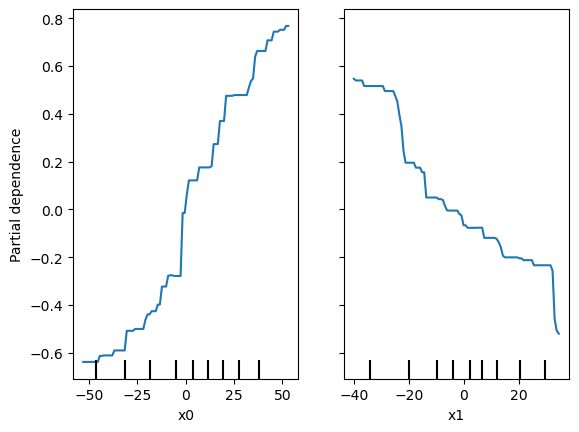

In [91]:
PartialDependenceDisplay.from_estimator(gb_pca, xtrain_pc, [0, 1])

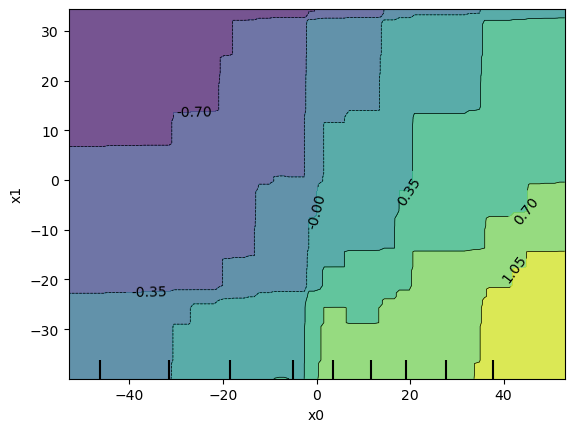

In [89]:
PartialDependenceDisplay.from_estimator(gb_pca, xtrain_pc, [[0, 1]])